<a href="https://colab.research.google.com/github/IkrashNoman/client-work/blob/main/Client_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hemil26/gold-rates-1985-jan-2022")

print("Path to dataset files:", path)

100%|██████████| 214k/214k [00:00<00:00, 48.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/hemil26/gold-rates-1985-jan-2022/versions/12


Rows: 43
   Year     USD
0  1980  614.50
1  1981  459.26
2  1982  375.30
3  1983  423.66
4  1984  360.78

Linear CV R2: 0.2986 +/- 0.4949

Poly3 CV R2: 0.7624 +/- 0.0949

Tuning SVR via GridSearchCV ...
  Best SVR params: {'svr__C': 100, 'svr__epsilon': 0.5, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
  Best CV R2: 0.6251

Tuning RF via GridSearchCV ...
  Best RF params: {'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
  Best CV R2: 0.9572

Tuning GB via GridSearchCV ...
  Best GB params: {'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__n_estimators': 100}
  Best CV R2: 0.9361

Linear test R2: 0.7403, MAE: 161.899, RMSE: 227.455

Poly3 test R2: 0.8081, MAE: 172.592, RMSE: 195.534

SVR test R2: 0.9563, MAE: 74.113, RMSE: 93.298

RF test R2: 0.9797, MAE: 53.703, RMSE: 63.535

GB test R2: 0.9611, MAE: 71.158, RMSE: 87.992

Best model on test set: RF (R2=0.9797)


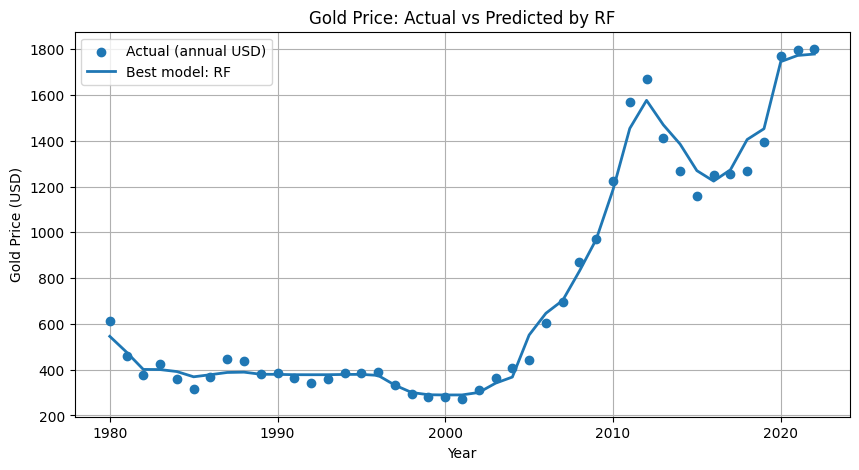

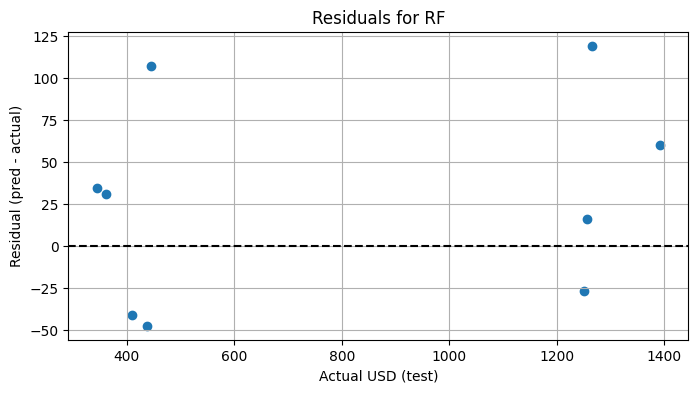

Predicted USD in 2025: 1778.98
Predicted USD in 2030: 1778.98
Saved best model to best_gold_model.joblib


In [11]:
# gold_model_compare.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------------------------
# 1. Load and prepare data
# ---------------------------
FILE = r"annual_gold_rate.csv"   # your provided file
df = pd.read_csv(FILE)

# Parse Date and extract Year
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])     # drop bad rows if any
df['Year'] = df['Date'].dt.year

# Keep only Year and USD (target). Drop rows with NaN USD.
df = df[['Year', 'USD']].dropna().sort_values('Year')

# Optionally: inspect
print("Rows:", len(df))
print(df.head())

X = df[['Year']].values
y = df['USD'].values

# Train/test split (keep recent years in test by using shuffle=False if you want time split,
# but for model comparison we'll use random split with a fixed seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# ---------------------------
# 2. Define models & pipelines
# ---------------------------
models = {}

# Baseline linear
models['Linear'] = Pipeline([('lr', LinearRegression())])

# Polynomial (degree 3) -> linear on poly features
models['Poly3'] = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('lr', LinearRegression())
])

# SVR with scaling
models['SVR'] = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Random Forest (no scaling required)
models['RF'] = Pipeline([
    ('rf', RandomForestRegressor(random_state=42))
])

# Gradient Boosting
models['GB'] = Pipeline([
    ('gb', GradientBoostingRegressor(random_state=42))
])

# ---------------------------
# 3. Hyperparameter grids
# ---------------------------
grids = {}

grids['Linear'] = {}
grids['Poly3'] = {}
grids['SVR'] = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [1, 10, 100],
    'svr__gamma': ['scale', 'auto'],
    'svr__epsilon': [0.1, 0.2, 0.5]
}
grids['RF'] = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5]
}
grids['GB'] = {
    'gb__n_estimators': [100, 300],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [2, 3, 5]
}

# ---------------------------
# 4. Model selection via GridSearchCV (CV on training set)
# ---------------------------
best_estimators = {}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, pipeline in models.items():
    grid = grids.get(name, {})
    if grid:
        print(f"\nTuning {name} via GridSearchCV ...")
        gs = GridSearchCV(pipeline, grid, scoring='r2', cv=cv, n_jobs=-1, verbose=0)
        gs.fit(X_train, y_train)
        print(f"  Best {name} params: {gs.best_params_}")
        print(f"  Best CV R2: {gs.best_score_:.4f}")
        best_estimators[name] = gs.best_estimator_
    else:
        # no grid -> fit directly
        pipeline.fit(X_train, y_train)
        # estimate cv r2
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
        print(f"\n{name} CV R2: {scores.mean():.4f} +/- {scores.std():.4f}")
        best_estimators[name] = pipeline

# ---------------------------
# 5. Evaluate on hold-out test set
# ---------------------------
def evaluate_model(name, est, X_test, y_test):
    preds = est.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5
    return {'name': name, 'r2': r2, 'mae': mae, 'rmse': rmse, 'preds': preds}

results = []
for name, est in best_estimators.items():
    # ensure final fit on full training data
    est.fit(X_train, y_train)
    res = evaluate_model(name, est, X_test, y_test)
    results.append(res)
    print(f"\n{name} test R2: {res['r2']:.4f}, MAE: {res['mae']:.3f}, RMSE: {res['rmse']:.3f}")

# Sort by R2
results_sorted = sorted(results, key=lambda r: r['r2'], reverse=True)
best = results_sorted[0]
print(f"\nBest model on test set: {best['name']} (R2={best['r2']:.4f})")

# ---------------------------
# 6. Plots for best model
# ---------------------------
best_name = best['name']
best_est = best_estimators[best_name]
y_pred = best['preds']

# For plotting continuous curve we predict across year range
years_all = np.arange(df['Year'].min(), df['Year'].max() + 1).reshape(-1, 1)
best_est.fit(X_train, y_train)  # already fit but safe
years_pred = best_est.predict(years_all)

plt.figure(figsize=(10,5))
plt.scatter(df['Year'], df['USD'], label='Actual (annual USD)', zorder=3)
plt.plot(years_all.flatten(), years_pred, label=f'Best model: {best_name}', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Gold Price (USD)')
plt.title(f'Gold Price: Actual vs Predicted by {best_name}')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot on test set
plt.figure(figsize=(8,4))
plt.scatter(y_test, best['preds'] - y_test)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Actual USD (test)')
plt.ylabel('Residual (pred - actual)')
plt.title(f'Residuals for {best_name}')
plt.grid(True)
plt.show()

# ---------------------------
# 7. Prediction helper
# ---------------------------
def predict_for_year(year, model=best_est):
    x = np.array([[int(year)]])
    return model.predict(x)[0]

# Example predictions
for yr in [2025, 2030]:
    print(f"Predicted USD in {yr}: {predict_for_year(yr):.2f}")

# ---------------------------
# 8. Save best model (optional)
# ---------------------------
import joblib
joblib.dump(best_est, r"best_gold_model.joblib")
print("Saved best model to best_gold_model.joblib")


In [9]:
!apt-get update
!apt-get install octave

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,519 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa

In [10]:
!octave -W work.m

Loaded rows: 129

Performance on Test Set:
--------------------------------------------------
Model      | R2       | MAE      | RMSE
--------------------------------------------------
Linear     | -0.1445   | 878.34   | 1354.77
Poly3      | -0.0382   | 755.65   | 1290.32

Best Model: Polynomial (Deg 3)

The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are ulikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update it's internal list of open figure windows.
We recommend using the qt toolkit instead.
                                                                               
                                                        